In [165]:
import PIL.Image
import os
import sys
sys.path.append('..') if '..' not in sys.path else print('Already included')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from utils.augment import RandomAugmentor

import torch
from torchvision import transforms as transforms
from torchvision.utils import make_grid
import torchvision.transforms.functional as F
import torchvision.transforms.functional as F

Already included


In [2]:
df = pd.read_csv('../data/split.csv')
print(df.shape)
df['concatenated_type'] = df['type'] + '/' + df['subtype']

(2212, 5)


In [3]:
df = df.drop_duplicates()

In [4]:
df.to_csv('../data/split.csv', index=False)

In [5]:
train = df[df['set'] == 'train'].drop_duplicates()
train.head(2)

,image,type,subtype,concatenated_type,set
0,100201600.png,Rost,Strassenrost,Rost/Strassenrost,train
1,100023200.png,Rost,Strassenrost,Rost/Strassenrost,train


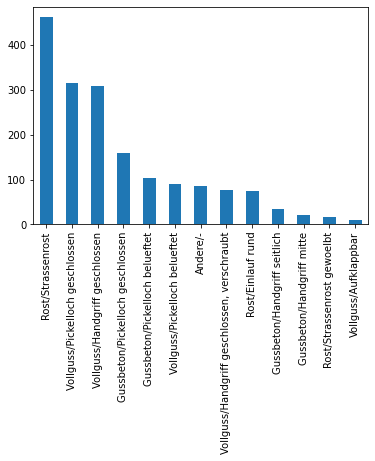

In [6]:
train['concatenated_type'].value_counts().plot(kind='bar')
plt.show()

## Augmentation Upsampling

In [270]:
rand_augment = RandomAugmentor(apply_n=3)

In [271]:
rand_augment._get_transformation()

Compose(
    ColorJitter(brightness=[0.5, 1.5], contrast=[0.5, 1.5], saturation=[0.5, 1.5], hue=[-0.5, 0.5])
    Grayscale(num_output_channels=3)
    Resize(size=128, interpolation=bilinear, max_size=None, antialias=None)
)

In [272]:
'_'.join(rand_augment.current_transforms)

'jit_gray_orig'

In [273]:
train = df[df['set'] == 'train']
train.head(2)

,image,type,subtype,concatenated_type,set
0,100201600.png,Rost,Strassenrost,Rost/Strassenrost,train
1,100023200.png,Rost,Strassenrost,Rost/Strassenrost,train


In [274]:
transformation_df = pd.DataFrame(data={'image': [], 
                                       'transforms': []})

In [275]:
max_count = 800

In [276]:
for ctype in tqdm(train['concatenated_type'].unique()):
    image_id = train.loc[train['concatenated_type'] == ctype, 'image'].to_numpy()
    upsample_diff = max_count # - train[train['concatenated_type'] == ctype].shape[0]

    sample_idx = np.random.choice(image_id, size=upsample_diff, replace=True)
        
    random_transforms = []
    for i in range(upsample_diff):
        _ = rand_augment._get_transformation()
        random_transforms.append('_'.join(rand_augment.current_transforms))
    tmp = pd.DataFrame.from_records(list(zip(sample_idx, random_transforms)), 
                                    columns=['image', 'transforms'])
    
    transformation_df = pd.concat([transformation_df, tmp], axis=0)

  0%|          | 0/13 [00:00<?, ?it/s]

In [277]:
transformation_df = transformation_df.drop_duplicates()
transformation_df.shape

(10123, 2)

In [298]:
transformation_df.head(3)

,image,transforms
0,100076000.png,rot_gray_fliph
1,100157800.png,fliph_jit_rot
2,100084600.png,orig_blur_fliph


In [299]:
tmp = pd.merge(left=transformation_df, right=train, how='right', left_on='image', right_on='image')
tmp.shape

(10242, 6)

In [300]:
tmp['concatenated_type'].value_counts()

Rost/Strassenrost                              866
Vollguss/Handgriff geschlossen                 820
Vollguss/Pickelloch geschlossen                819
Vollguss/Pickelloch belueftet                  795
Gussbeton/Pickelloch geschlossen               793
Gussbeton/Pickelloch belueftet                 793
Rost/Einlauf rund                              793
Vollguss/Handgriff geschlossen, verschraubt    788
Andere/-                                       786
Gussbeton/Handgriff seitlich                   777
Gussbeton/Handgriff mitte                      765
Rost/Strassenrost gewoelbt                     746
Vollguss/Aufklappbar                           701
Name: concatenated_type, dtype: int64

In [304]:
selected_type = tmp['concatenated_type'].value_counts().index[1]

In [305]:
A = tmp.loc[tmp['concatenated_type'] == selected_type, 'image'].unique()
B = train.loc[train['concatenated_type'] == selected_type,  'image'].unique()
np.isin(B, A).shape[0] - np.isin(B, A).sum()

0

In [306]:
tmp.head(2)

,image,transforms,type,subtype,concatenated_type,set
0,100201600.png,orig_pers_flipv,Rost,Strassenrost,Rost/Strassenrost,train
1,100201600.png,blur_pers_rot,Rost,Strassenrost,Rost/Strassenrost,train


In [337]:
tmp.isnull().sum()

image                0
transforms           0
type                 0
subtype              0
concatenated_type    0
set                  0
dtype: int64

In [326]:
tmp.loc[tmp['transforms'].isnull()]

,image,transforms,type,subtype,concatenated_type,set
33,100216700.png,NaN,Gussbeton,Pickelloch geschlossen,Gussbeton/Pickelloch geschlossen,train
93,100020800.png,NaN,Rost,Strassenrost,Rost/Strassenrost,train
173,100074700.png,NaN,Vollguss,Handgriff geschlossen,Vollguss/Handgriff geschlossen,train
183,100057000.png,NaN,Rost,Strassenrost,Rost/Strassenrost,train
196,100081300.png,NaN,Vollguss,Handgriff geschlossen,Vollguss/Handgriff geschlossen,train
...,...,...,...,...,...,...
9874,100047600.png,NaN,Rost,Strassenrost,Rost/Strassenrost,train
9960,100193700.png,NaN,Rost,Strassenrost,Rost/Strassenrost,train
10087,100164100.png,NaN,Rost,Strassenrost,Rost/Strassenrost,train
10180,100121300.png,NaN,Vollguss,Pickelloch geschlossen,Vollguss/Pickelloch geschlossen,train


In [333]:
tmp.loc[33, 'transforms'] == False

True

In [331]:
tmp = tmp.fillna(value=0)

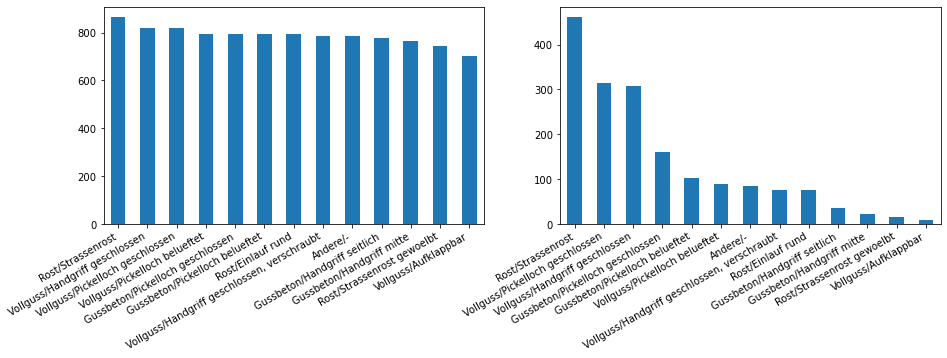

In [334]:
plt.subplots(figsize=(15, 4))

plt.subplot(1,2,1)
tmp.drop_duplicates().loc[:,'concatenated_type'].value_counts().plot(kind='bar')
plt.xticks(rotation=30, ha='right')

plt.subplot(1,2,2)
train['concatenated_type'].value_counts().plot(kind='bar')
plt.xticks(rotation=30, ha='right')

plt.show()

In [311]:
transformed_samples = []
for _ in range(20):
    img_id = tmp.sample(1)['image'].iloc[0]
    img = PIL.Image.open(f'../data/images_transformed/{img_id}')
    img = rand_augment.transform_given_key(img, tmp.loc[tmp['image'] == img_id, 'transforms'].iloc[0].split('_'))
    img = transforms.Compose([transforms.Resize(128), transforms.ToTensor()])(img)
    transformed_samples.append(img)

In [335]:
plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(12, 12))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

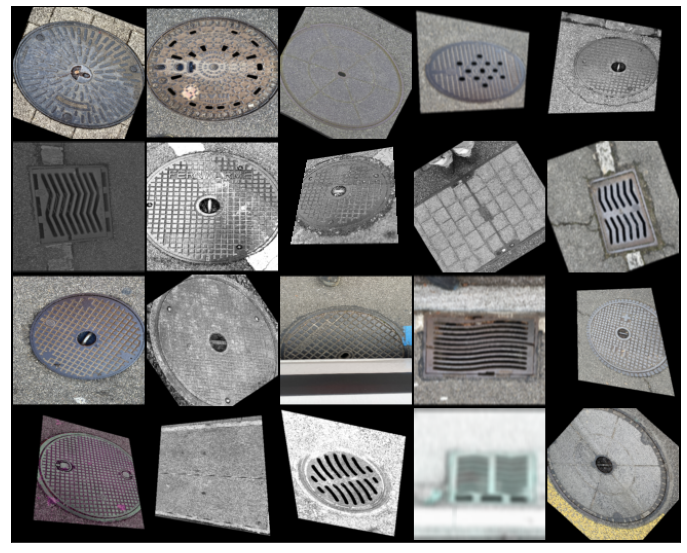

In [336]:
show(make_grid(transformed_samples, nrow=5))

In [339]:
tmp.to_csv('../data/transformation_split.csv', index=False)

In [370]:
tmp = pd.read_csv('../data/transformation_split.csv')

In [371]:
foo = list(tmp[['image', 'transforms']].to_records(index=False))

In [375]:
tmp_ = list(tmp[['image', 'transforms']].to_records(index=False))
file_names = [f[0] for f in tmp_]
transforms_ = [f[1] for f in tmp_]
from_ = [os.path.join('../../data/images', name) for name in file_names]
to_ = [os.path.join('../../data/images_transformed', name) for name in file_names]